In [24]:
from __future__ import division

import pandas as pd
import matplotlib
import sys

from alibi_detect.datasets import fetch_kdd

import numpy as np
import matplotlib.pyplot as plt  # corrected from import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
import ruptures as rpt


sys.path.append("../")

from bayesian_changepoint_detection_folder.bayesian_changepoint_detection.generate_data import (
    generate_normal_time_series,
)


%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext lab_black

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


# Anomaly Detection

In [25]:
intrusions = fetch_kdd()

In [26]:
intrusions["feature_names"]

['srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate']

<AxesSubplot:>

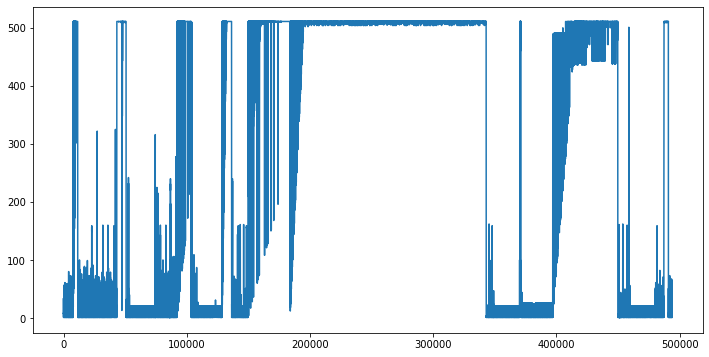

In [27]:
fig, ax = plt.subplots(figsize=[12, 6])
pd.Series(intrusions["data"][:, 0]).plot()

We'll load and run the SpectralResidual model that implements the method
proposed by Microsoft:

In [28]:
from alibi_detect.od import SpectralResidual

od = SpectralResidual(
    threshold=1.0, window_amp=20, window_local=20, n_est_points=10, n_grad_points=5
)

We can then get the anomaly scores for each point in our time-series:
    

In [29]:
scores = od.score(intrusions["data"][:, 0])
scores

array([ 1.50887862,  0.19287179,  0.26393776, ..., -0.06723122,
        0.26368727,  1.35195662])

Let's plot the scores imposed on top of our time-series!

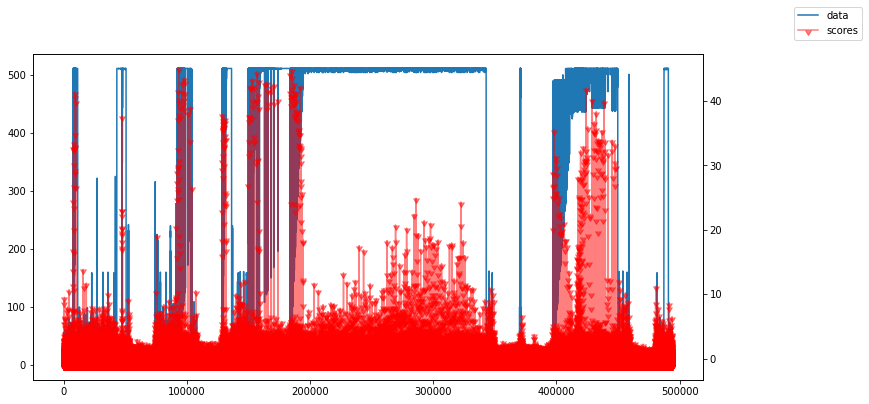

In [30]:
ax = pd.Series(intrusions["data"][:, 0], name="data").plot(
    legend=False, figsize=(12, 6)
)
ax2 = ax.twinx()
ax = pd.Series(scores, name="scores").plot(
    ax=ax2, legend=False, color="r", marker=matplotlib.markers.CARETDOWNBASE, alpha=0.5
)
ax.figure.legend(bbox_to_anchor=(1, 1), loc="upper left")

# Changepoint detection

We'll first create a synthetic multivariate time-series with the ruptures library. We'll
set the number of dimensions to 3 and the length of the time-series to 500, and our
time-series will have 3 change points and a Gaussian noise of standard deviation 5.0
will be over imposed:

In [31]:
signal, bkps = rpt.pw_constant(
    n_samples=500, n_features=3, n_bkps=3, noise_std=5.0, delta=(1, 20)
)

In [32]:
signal[:5]

array([[  0.44396721,  -6.28963937, -12.88187512],
       [  2.05982663,  -4.83964891, -18.57350601],
       [-13.11952909,  -6.66768115, -17.46511539],
       [-10.56621845, -11.8745335 ,  -8.38365717],
       [ -8.09754779,  -1.30243093, -19.4923553 ]])

We can plot this time-series with a utility function that highlights the subsections
separated by changepoints:

(<Figure size 720x432 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

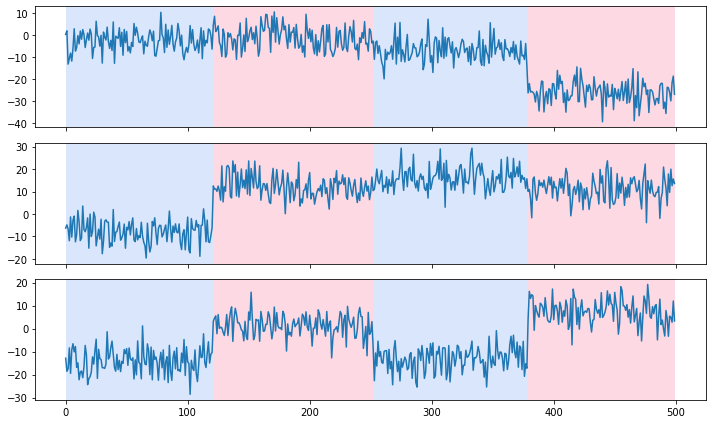

In [33]:
rpt.display(signal, bkps)

We can apply Binary Segmentation to this time-series. ruptures follows the scikitlearn
conventions, so if you have used scikit-learn before, the usage should be very
intuitive:

In [34]:
algo = rpt.Binseg(model="l1").fit(signal)
my_bkps = algo.predict(n_bkps=3)

We can plot the predictions of the Binary Segmentation with another utility function:

(<Figure size 720x432 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

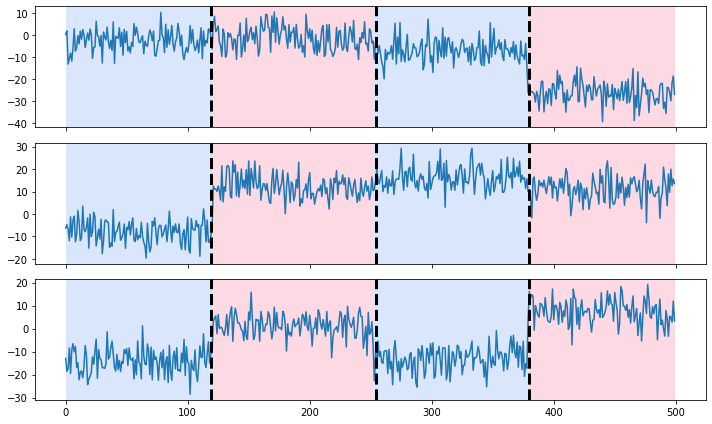

In [35]:
rpt.show.display(signal, bkps, my_bkps, figsize=(10, 6))

## Bayesian Changepoint Detection in Python


In [36]:
partition, data = generate_normal_time_series(7, 50, 200)

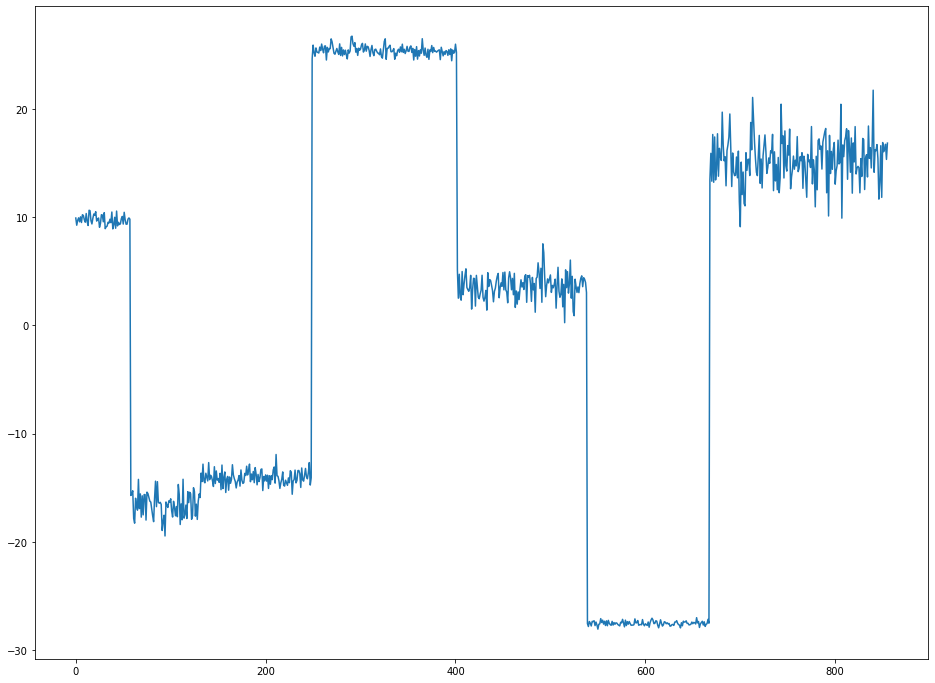

In [37]:
fig, ax = plt.subplots(figsize=[16, 12])
ax.plot(data)

### Offline Changepoint Detection
Lets compute the probability of changepoints at each time step. We need two things for that. First a prior of how probable is it to have two successive changepoints with the distance t. 
The second thing is a model of the likelihood of data in a sequence [s, t] of the data, given that in this sequence there is no changepoint.

For this example we assume a uniform prior over the length of sequences (const_prior) and a piecewise gaussian model (gaussian_obs_log_likelihood).

In [38]:
from bayesian_changepoint_detection_folder.bayesian_changepoint_detection.priors import (
    const_prior,
)
from functools import partial

prior_function = partial(const_prior, p=1 / (len(data) + 1))

In [39]:
from bayesian_changepoint_detection_folder.bayesian_changepoint_detection.bayesian_models import (
    offline_changepoint_detection,
)

In [40]:
import bayesian_changepoint_detection_folder.bayesian_changepoint_detection.offline_likelihoods as offline_ll

In [41]:
offline_ll.StudentT()

In [42]:
Q, P, Pcp = offline_changepoint_detection(
    data, prior_function, offline_ll.StudentT(), truncate=-40
)

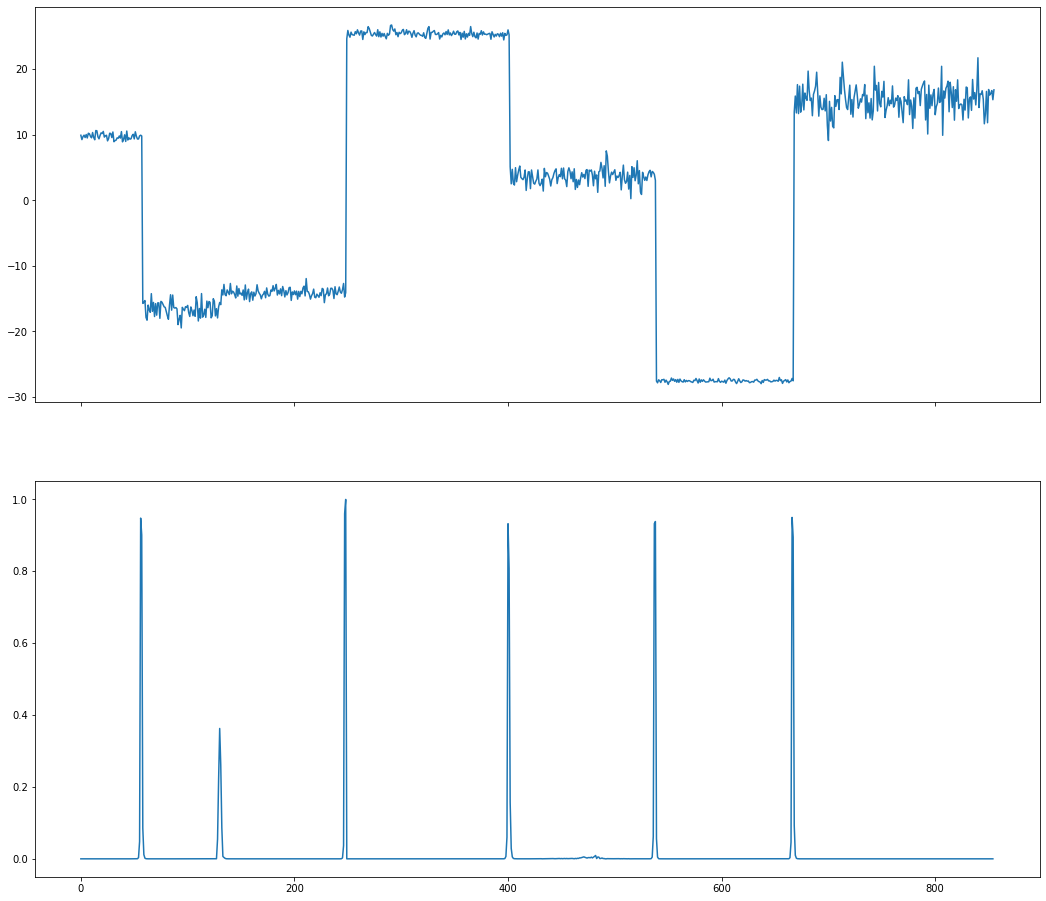

In [43]:
fig, ax = plt.subplots(2, figsize=[18, 16], sharex=True)
ax[0].plot(data[:])
ax[1].plot(np.exp(Pcp).sum(0))

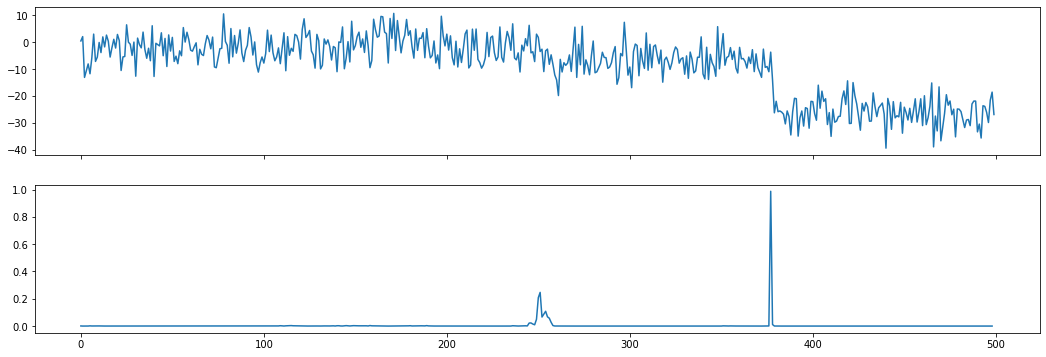

In [51]:
Q, P, Pcp = offline_changepoint_detection(
    signal[:, 0], prior_function, offline_ll.StudentT(), truncate=-40
)
fig, ax = plt.subplots(2, figsize=[18, 6], sharex=True)
ax[0].plot(signal[:, 0])
ax[1].plot(np.exp(Pcp).sum(0))

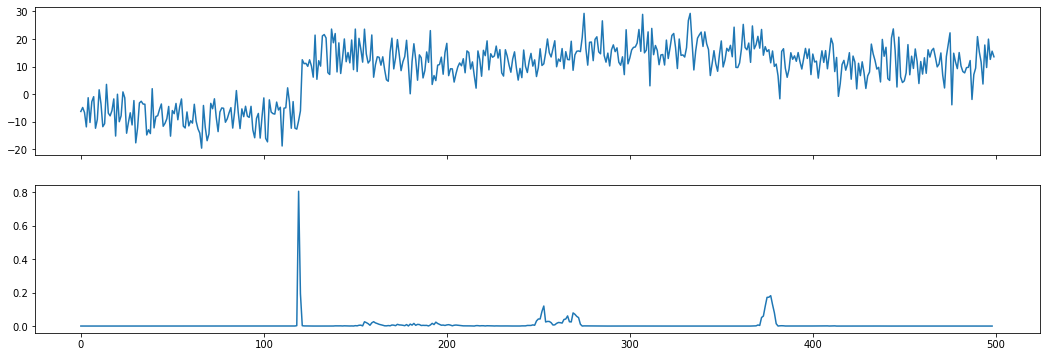

In [52]:
Q, P, Pcp = offline_changepoint_detection(
    signal[:, 1], prior_function, offline_ll.StudentT(), truncate=-40
)
fig, ax = plt.subplots(2, figsize=[18, 6], sharex=True)
ax[0].plot(signal[:, 1])
ax[1].plot(np.exp(Pcp).sum(0))

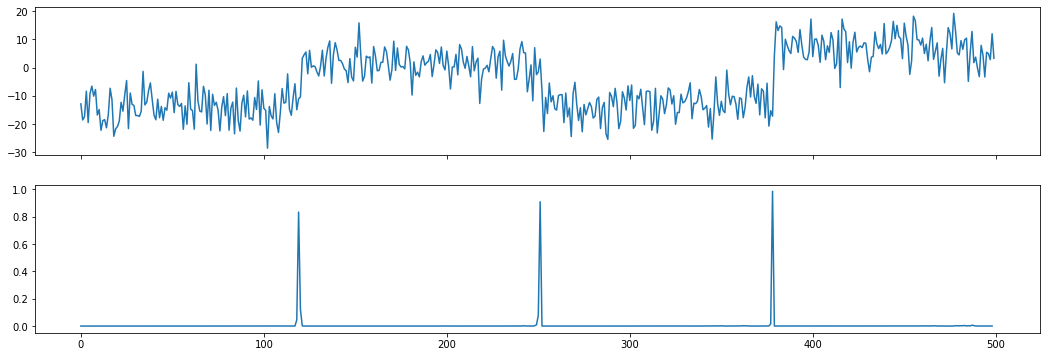

In [53]:
Q, P, Pcp = offline_changepoint_detection(
    signal[:, 2], prior_function, offline_ll.StudentT(), truncate=-40
)
fig, ax = plt.subplots(2, figsize=[18, 6], sharex=True)
ax[0].plot(signal[:, 2])
ax[1].plot(np.exp(Pcp).sum(0))

### Online Changepoint Detection

## Bayesian Changepoint Detection

In [56]:
import math


def step4(d):

    n = len(d)
    # dbar = sum(d)/float(n)
    dbar = np.mean(d)

    # dsbar = sum (d*d)/float(n)
    dsbar = np.mean(np.multiply(d, d))

    fac = dsbar - np.square(dbar)

    summ = 0
    summup = []

    for z in range(n):
        summ += d[z]
        summup.append(summ)

    y = []

    for m in range(n - 1):
        pos = m + 1
        mscale = 4 * (pos) * (n - pos)
        Q = summup[m] - (summ - summup[m])
        U = -np.square(dbar * (n - 2 * pos) + Q) / float(mscale) + fac
        y.append(
            -(n / float(2) - 1) * math.log(n * U / 2)
            - 0.5 * math.log((pos * (n - pos)))
        )

    z, zz = np.max(y), np.argmax(y)

    mean1 = sum(d[: zz + 1]) / float(len(d[: zz + 1]))
    mean2 = sum(d[(zz + 1) : n]) / float(n - 1 - zz)

    return y, zz, mean1, mean2

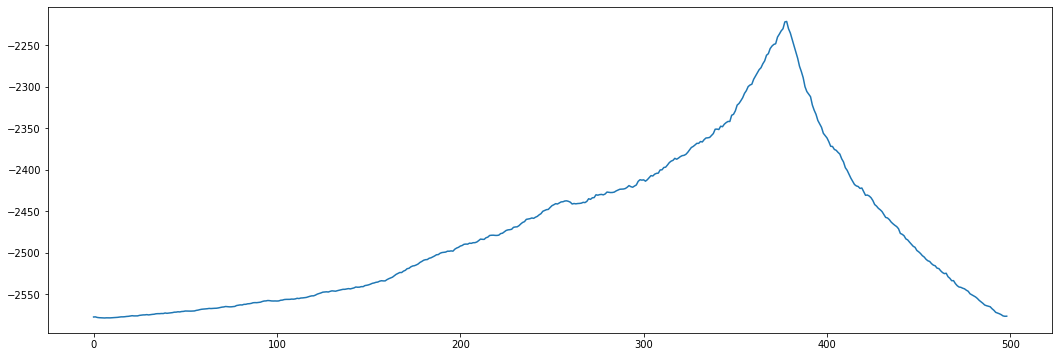

In [57]:
y, zz, mean1, mean2 = step4(signal[:, 0])
fig, ax = plt.subplots(figsize=[18, 6])
plt.plot(y)

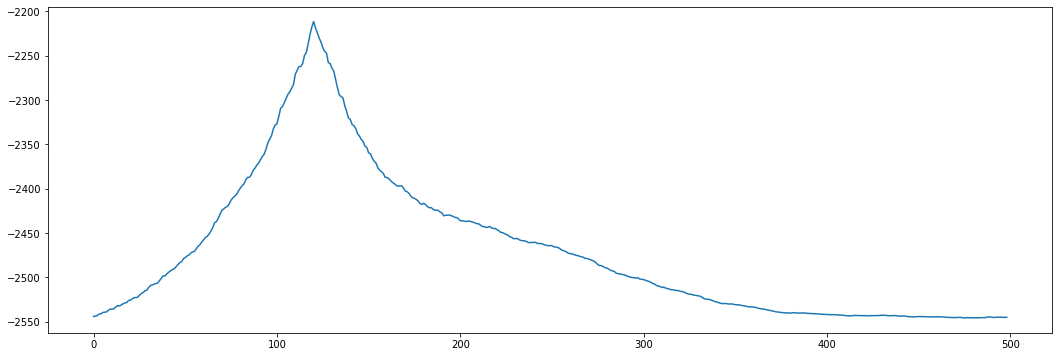

In [58]:
y, zz, mean1, mean2 = step4(signal[:, 1])
fig, ax = plt.subplots(figsize=[18, 6])
plt.plot(y)

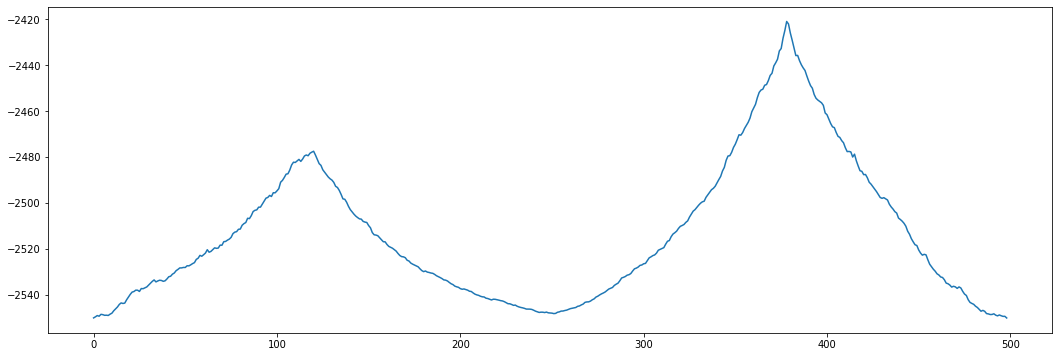

In [59]:
y, zz, mean1, mean2 = step4(signal[:, 2])
fig, ax = plt.subplots(figsize=[18, 6])
plt.plot(y)